# Diabetes Patients Readmittance Prediction

The purpose of this notebook is to predict the diabetes that will be readmitted within 30 days.
The source of the dataset can be found at https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#

The original dataset are separated to '<30', '>30', and 'NO' for the readmitted variable, while most hospitals usually take interest to the ones that readmitted within 30 days.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
#Loading the dataset
diabetes = pd.read_csv('diabetic_data.csv')

In [3]:
#The data has around 100 thousands of row and 50 columns
diabetes.shape

(101766, 50)

In [4]:
#Checking the response variable
print(diabetes.readmitted.unique())
print(diabetes.readmitted.value_counts())

['NO' '>30' '<30']
NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64


In [5]:
# The goal of prediction is to as correctly as possible predict the patient that will be readmitted within 30 days
# after release. The reason is that wrongly predict the particular patients will impact on the business and
# preparedness of the hospital in handling them.
diabetes.loc[diabetes.readmitted == '>30', 'readmitted'] = '>30 OR NO'
diabetes.loc[diabetes.readmitted == 'NO', 'readmitted'] = '>30 OR NO'
# diabetes.loc[diabetes.readmitted == '<30', 'readmitted'] = 1

In [6]:
diabetes['readmitted'] = diabetes['readmitted'].replace('>30 OR NO', 0)
diabetes['readmitted'] = diabetes['readmitted'].replace('<30', 1)

In [7]:
diabetes.readmitted.value_counts()
# As we see, that the case of this study is categorized as imbalanced class case.

0    90409
1    11357
Name: readmitted, dtype: int64

## Data preprocessing

### Duplication on patient_nbr

In [8]:
#Caused by multiple admission of patient, in this case we decided to take only the first admission, to avoid bias on the data.
diabetes = diabetes.sort_values(['patient_nbr', 'encounter_id'])
diabetes = diabetes[~diabetes.patient_nbr.duplicated()]

### Removing useless columns

In [9]:
diabetes.head(5)
#note that missing value is encoded by '?' in the dataset

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
4267,24437208,135,Caucasian,Female,[50-60),?,2,1,1,8,...,No,Steady,No,No,No,No,No,Ch,Yes,1
5827,29758806,378,Caucasian,Female,[50-60),?,3,1,1,2,...,No,No,No,No,No,No,No,No,No,0
67608,189899286,729,Caucasian,Female,[80-90),?,1,3,7,4,...,No,No,No,No,No,No,No,No,Yes,0
17494,64331490,774,Caucasian,Female,[80-90),?,1,1,7,3,...,No,No,No,No,No,No,No,Ch,Yes,0
2270,14824206,927,AfricanAmerican,Female,[30-40),?,1,1,7,5,...,No,No,No,No,No,No,No,No,Yes,0


In [10]:
# replacing '?' with NaN, default missing value encoding to make preprocessing easier
diabetes = diabetes.replace('?', np.nan)

In [11]:
# checking the missing percentage
diabetes.isna().sum() / len(diabetes) * 100
# from this, we can notice that weight are useless, as it contains 96% missing values
# encounter_id, patient_nbr, payer_code will be removed as well as they do not have any value for the prediction

encounter_id                 0.000000
patient_nbr                  0.000000
race                         2.723790
gender                       0.000000
age                          0.000000
weight                      96.010794
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
payer_code                  43.405856
medical_specialty           48.207444
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       0.015381
diag_2                       0.411085
diag_3                       1.712856
number_diagnoses             0.000000
max_glu_serum                0.000000
A1Cresult                    0.000000
metformin                    0.000000
repaglinide                  0.000000
nateglinide 

In [12]:
diabetes.drop(['weight', 'encounter_id', 'patient_nbr', 'payer_code', 'medical_specialty'], axis=1, inplace=True)

In [13]:
diabetes.nunique()
## removing columns with single value => examide, citoglipton
diabetes.drop(['examide', 'citoglipton'], axis=1, inplace=True)

### Removing rows with missing some missing values

In [14]:
# column race
diabetes = diabetes[~diabetes.race.isna()]
# rows with diag_1, diag_2, diag_3 missing at the same time
diabetes = diabetes[~(diabetes.diag_1.isna() & diabetes.diag_2.isna() & diabetes.diag_3.isna())]

In [15]:
# removing records with gender = 'Unknown/Invalid'
diabetes = diabetes[diabetes.gender != 'Unknown/Invalid']

### Simplify features

In [16]:
# To identify changes of medication (23 types of medication), we want to count every changes that occured
# for each type of medication
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

for col in keys:
    colname = str(col) + 'temp'
    diabetes[colname] = diabetes[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)
    
diabetes['numchange'] = 0
for col in keys:
    colname = str(col) + 'temp'
    diabetes['numchange'] = diabetes['numchange'] + diabetes[colname]
    del diabetes[colname]

In [17]:
# To identify changes of medication (23 types of medication), we want to count every changes that occured
# for each type of medication
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

for col in keys:
    colname = str(col) + 'temp'
    diabetes[colname] = diabetes[col].apply(lambda x: 0 if (x == 'No') else 1)
    
diabetes['nummed'] = 0
for col in keys:
    colname = str(col) + 'temp'
    diabetes['nummed'] = diabetes['nummed'] + diabetes[colname]
    del diabetes[colname]

In [18]:
# duplicate the diagnosis column
diabetes['level1_diag1'] = diabetes['diag_1']
# replace the unknown values with -1
diabetes['diag_1'] = diabetes['diag_1'].fillna('?')
diabetes['level1_diag1'] = diabetes['level1_diag1'].fillna(-1)
# recode the disease codes starting with V or E are in “other” category to 0
diabetes.loc[diabetes['diag_1'].str.contains('V'), ['level1_diag1']] = 0
diabetes.loc[diabetes['diag_1'].str.contains('E'), ['level1_diag1']] = 0

In [19]:
diabetes['level1_diag1'] = diabetes.level1_diag1.astype(float)

In [20]:
# iterate and recode disease codes between certain ranges to certain categories
for index, row in diabetes.iterrows():
    if (row['level1_diag1'] >= 390 and row['level1_diag1'] < 460) or (np.floor(row['level1_diag1']) == 785):
        diabetes.loc[index, 'level1_diag1'] = 1
    elif (row['level1_diag1'] >= 460 and row['level1_diag1'] < 520) or (np.floor(row['level1_diag1']) == 786):
        diabetes.loc[index, 'level1_diag1'] = 2
    elif (row['level1_diag1'] >= 520 and row['level1_diag1'] < 580) or (np.floor(row['level1_diag1']) == 787):
        diabetes.loc[index, 'level1_diag1'] = 3
    elif (np.floor(row['level1_diag1']) == 250):
        diabetes.loc[index, 'level1_diag1'] = 4
    elif (row['level1_diag1'] >= 800 and row['level1_diag1'] < 1000):
        diabetes.loc[index, 'level1_diag1'] = 5
    elif (row['level1_diag1'] >= 710 and row['level1_diag1'] < 740):
        diabetes.loc[index, 'level1_diag1'] = 6
    elif (row['level1_diag1'] >= 580 and row['level1_diag1'] < 630) or (np.floor(row['level1_diag1']) == 788):
        diabetes.loc[index, 'level1_diag1'] = 7
    elif (row['level1_diag1'] >= 140 and row['level1_diag1'] < 240):
        diabetes.loc[index, 'level1_diag1'] = 8
    else:
        diabetes.loc[index, 'level1_diag1'] = 0
# convert this variable to float type to enable computations later
# diabetes['level1_diag1'] = diabetes['level1_diag1'].astype(float)

In [21]:
# changing it to string to negate the illusion of ordinality of the diagnosis
diabetes['level1_diag1'] = diabetes.level1_diag1.astype(str)

In [22]:
diabetes['level1_diag1'] = diabetes.level1_diag1.str.replace('.0', '')

In [23]:
diabetes[['diag_1','level1_diag1']].head(15).T

,4267,5827,67608,17494,2270,1164,18234,15848,61382,2279,7866,25911,1083,2001,11049
diag_1,401,722,820,274,590,282,491,996,V57,682,414,722,276,434,38
level1_diag1,1,6,5,0,7,0,2,5,0,0,1,6,0,1,0


### Removing records with particular discharge_disposition_id

In [24]:
#To avoid bias, removing records with discharge_disposition_id that indicated that the patient was sent to hospice or dead,
#using IDs_mapping.csv as the reference => ID: {11,13,14,19,20,21}
diabetes = diabetes[~(diabetes.discharge_disposition_id.isin([11, 13, 14, 19, 20, 21]))]

### Changing/Encoding values of columns

In [25]:
diabetes.age.unique()
# As we can see here that the age is coded as a categorical variable,
# we want to see the effect of the increasing age to the prediction,
# hence we recode the age as a numeric variable using the mean of each age group.

array(['[50-60)', '[80-90)', '[30-40)', '[60-70)', '[40-50)', '[70-80)',
       '[10-20)', '[90-100)', '[20-30)', '[0-10)'], dtype=object)

In [26]:
diabetes.loc[diabetes.age == '[0-10)', 'age'] = 5
diabetes.loc[diabetes.age == '[10-20)', 'age'] = 15
diabetes.loc[diabetes.age == '[20-30)', 'age'] = 25
diabetes.loc[diabetes.age == '[30-40)', 'age'] = 35
diabetes.loc[diabetes.age == '[40-50)', 'age'] = 45
diabetes.loc[diabetes.age == '[50-60)', 'age'] = 55
diabetes.loc[diabetes.age == '[60-70)', 'age'] = 65
diabetes.loc[diabetes.age == '[70-80)', 'age'] = 75
diabetes.loc[diabetes.age == '[80-90)', 'age'] = 85
diabetes.loc[diabetes.age == '[90-100)', 'age'] = 95

In [27]:
#Looking at IDs_mapping.csv, recode Emergency, Urgent Care and Trauma to the same Category
#And recode NULL and Not Mapped to Not Available
diabetes['admission_type_id'] = diabetes['admission_type_id'].replace(2,1)
diabetes['admission_type_id'] = diabetes['admission_type_id'].replace(7,1)
diabetes['admission_type_id'] = diabetes['admission_type_id'].replace(6,5)
diabetes['admission_type_id'] = diabetes['admission_type_id'].replace(8,5)

In [28]:
#Looking at IDs_mapping.csv, recategorize discharge_disposition_id to the similar categories
#including null values
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(6,1)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(3,2)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(4,2)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(5,2)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(10,2)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(16,2)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(22,2)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(23,2)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(24,2)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(27,2)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(28,2)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(29,2)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(30,2)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(12,9)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(15,9)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(17,9)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(25,18)
diabetes['discharge_disposition_id'] = diabetes['discharge_disposition_id'].replace(26,18)

In [29]:
#Looking at IDs_mapping.csv, recategorize admission_source_id to the similar categories
#including null values
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(2,1)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(3,1)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(8,1)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(5,4)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(6,4)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(10,4)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(18,4)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(24,4)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(25,4)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(26,4)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(11,7)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(12,7)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(13,7)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(14,7)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(19,7)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(22,7)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(23,7)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(17,15)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(20,15)
diabetes['admission_source_id'] = diabetes['admission_source_id'].replace(21,15)

In [30]:
#Previous study stated that change on medication and diabetes medication have an impact on the readmission,
#hence both are recoded to ordinal data
diabetes['change'] = diabetes['change'].replace('Ch', 1)
diabetes['change'] = diabetes['change'].replace('No', 0)
diabetes['diabetesMed'] = diabetes['diabetesMed'].replace('Yes', 1)
diabetes['diabetesMed'] = diabetes['diabetesMed'].replace('No', 0)

#reducing levels on diabetes medication to given treatment or not
for col in keys:
    diabetes[col] = diabetes[col].replace('No', 0)
    diabetes[col] = diabetes[col].replace('Steady', 1)
    diabetes[col] = diabetes[col].replace('Up', 1)
    diabetes[col] = diabetes[col].replace('Down', 1)

In [31]:
#Recode Hb1Ac, max_glu_serum
#Hb1Ac >7 and >8 => 1, Hb1Ac Norm => 0, Hb1Ac None => -1
diabetes['A1Cresult'] = diabetes['A1Cresult'].replace('>7', 1)
diabetes['A1Cresult'] = diabetes['A1Cresult'].replace('>8', 1)
diabetes['A1Cresult'] = diabetes['A1Cresult'].replace('Norm', 0)
diabetes['A1Cresult'] = diabetes['A1Cresult'].replace('None', -1)

#max_glu_serum >200 and >300 => 1, max_glu_serum Norm => 0, max_glu_serum None => -1
diabetes['max_glu_serum'] = diabetes['max_glu_serum'].replace('>200', 1)
diabetes['max_glu_serum'] = diabetes['max_glu_serum'].replace('>300', 1)
diabetes['max_glu_serum'] = diabetes['max_glu_serum'].replace('Norm', 0)
diabetes['max_glu_serum'] = diabetes['max_glu_serum'].replace('None', -1)

In [32]:
diabetes = diabetes.join(pd.get_dummies(diabetes[['race', 'gender', 'level1_diag1']]))
diabetes.drop(['race', 'gender', 'diag_1', 'diag_2', 'diag_3', 'level1_diag1'], axis=1, inplace=True)

In [33]:
diabetes['admission_type_id'] = diabetes.admission_type_id.astype(str)
diabetes['admission_source_id'] = diabetes.admission_source_id.astype(str)
diabetes['discharge_disposition_id'] = diabetes.discharge_disposition_id.astype(str)
diabetes = diabetes.join(pd.get_dummies(diabetes[['admission_type_id', 'admission_source_id', 'discharge_disposition_id']]))
diabetes.drop(['admission_type_id', 'admission_source_id', 'discharge_disposition_id'], axis=1, inplace=True)

In [34]:
diabetes['A1Cresult'] = diabetes.A1Cresult.astype(str)
diabetes['max_glu_serum'] = diabetes.max_glu_serum.astype(str)
diabetes = diabetes.join(pd.get_dummies(diabetes[['A1Cresult', 'max_glu_serum']]))
diabetes.drop(['A1Cresult', 'max_glu_serum'], axis=1, inplace=True)

In [35]:
diabetes['num_use'] = diabetes.number_emergency + diabetes.number_inpatient + diabetes.number_outpatient
diabetes.drop(['number_emergency', 'number_inpatient', 'number_outpatient'], axis=1, inplace=True)

In [36]:
diabetes.drop(['A1Cresult_-1', 'max_glu_serum_-1'], axis=1, inplace=True)

In [37]:
# increase row display limit
pd.options.display.max_rows = 400
# calculate correlation matrix and store as absolute values
c = diabetes.corr().abs()
# unstake the table
s = c.unstack()
# sort the values in descending order
so = s.sort_values(ascending=False)
# display the most relevant part of the list
so[38:120]

num_procedures               num_procedures                 1.000000
num_medications              num_medications                1.000000
number_diagnoses             number_diagnoses               1.000000
metformin                    metformin                      1.000000
repaglinide                  repaglinide                    1.000000
nateglinide                  nateglinide                    1.000000
chlorpropamide               chlorpropamide                 1.000000
glimepiride                  glimepiride                    1.000000
acetohexamide                acetohexamide                  1.000000
glipizide                    glipizide                      1.000000
glyburide                    glyburide                      1.000000
tolbutamide                  tolbutamide                    1.000000
rosiglitazone                rosiglitazone                  1.000000
race_Asian                   race_Asian                     1.000000
acarbose                     acarb

In [38]:
diabetes.drop(['diabetesMed'], axis=1, inplace=True)

In [39]:
interactionterms = [('num_medications','time_in_hospital'), 
                    ('num_medications','num_procedures'), 
                    ('time_in_hospital','num_lab_procedures'),
                    ('num_medications','num_lab_procedures'), 
                    ('num_medications','number_diagnoses'),
                    ('age','number_diagnoses'), 
                    ('change','num_medications'), 
                    ('number_diagnoses','time_in_hospital'), 
                    ('num_medications','numchange')]
 
for inter in interactionterms:
    name = inter[0] + '|' + inter[1]
    diabetes[name] = diabetes[inter[0]] * diabetes[inter[1]]

## Distributions

Text(0.5, 1.0, 'Time in Hospital')

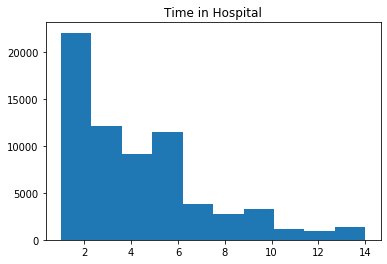

In [40]:
plt.hist(diabetes.time_in_hospital)
plt.title('Time in Hospital')

Text(0.5, 1.0, 'Age')

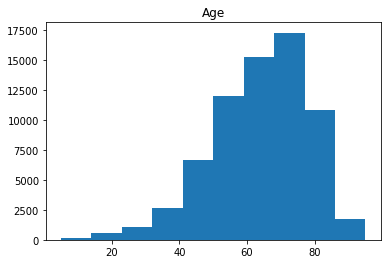

In [41]:
plt.hist(diabetes.age)
plt.title('Age')

Text(0.5, 1.0, 'Number of Lab Procedures')

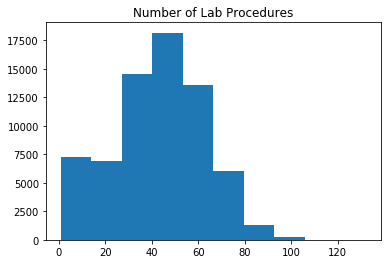

In [42]:
plt.hist(diabetes.num_lab_procedures)
plt.title('Number of Lab Procedures')

Text(0.5, 1.0, 'Number of Medications')

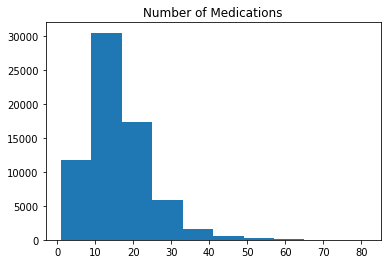

In [43]:
plt.hist(diabetes.num_medications)
plt.title('Number of Medications')

Text(0.5, 1.0, 'Number of Procedures')

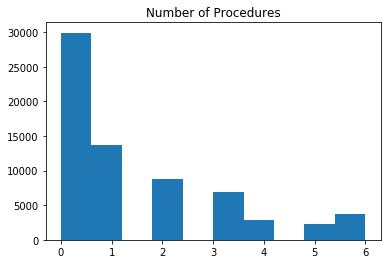

In [44]:
plt.hist(diabetes.num_procedures)
plt.title('Number of Procedures')

Text(0.5, 1.0, 'Number of Use')

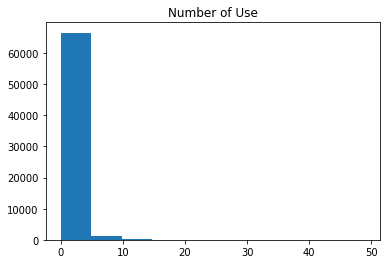

In [45]:
plt.hist(diabetes.num_use)
plt.title('Number of Use')

Text(0.5, 1.0, '')

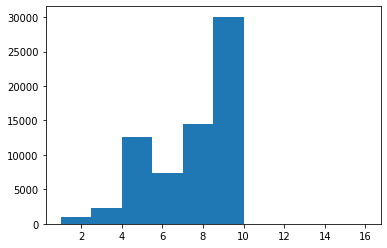

In [46]:
plt.hist(diabetes.number_diagnoses)
plt.title('')

In [47]:
diabetes.num_use.kurtosis()

97.74043474655947

## Split to train and test data

### Extract the response variable (label)

In [48]:
features = diabetes.drop('readmitted', axis=1)
label = diabetes['readmitted']

In [49]:
#To avoid information leakage from the future (test) data, the data is split to train and test data first.
#before normalize and standardize the features
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.33, random_state=42)

## Normalize Distribution

In [50]:
#As can be seen from the histograms; time_in_hospital, num_lab_procedures, num_procedures, num_medications, num_use distribution's are skewed
#hence they will be normalized using lognormal.

In [51]:
X_train['time_in_hospital'] = np.log1p(X_train.time_in_hospital)
X_train['num_lab_procedures'] = np.log1p(X_train.num_lab_procedures)
X_train['num_procedures'] = np.log1p(X_train.num_procedures)
X_train['num_medications'] = np.log1p(X_train.num_medications)
X_train['num_use'] = np.log1p(X_train.num_use)

D:\Programs\Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Programs\Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Programs\Tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [52]:
numerics = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'num_use', 'age', 'number_diagnoses']
X_train[numerics] = (X_train[numerics] - np.mean(X_train[numerics], axis=0)) / np.std(X_train[numerics], axis=0)

D:\Programs\Tools\Anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [53]:
#removing outliers using z-score
X_train = X_train[(np.abs(stats.zscore(X_train[numerics])) < 3).all(axis=1)]

In [66]:
y_train = y_train[y_train.index.isin(X_train.index)]

In [55]:
X_train.columns

Index(['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_diagnoses', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'numchange', 'nummed',
       'race_AfricanAmerican', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
       'race_Other', 'gender_Female', 'gender_Male', 'level1_diag1_0',
       'level1_diag1_1', 'level1_diag1_2', 'level1_diag1_3', 'level1_diag1_4',
       'level1_diag1_5', 'level1_diag1_6', 'level1_diag1_7', 'level1_diag1_8',
       'admission_type_id_1', 'admission_type_id_3', 'admission_type_id_4',
       'admission_type_id_5', 'admission_source_id_1',
      

In [56]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [57]:
print('Original dataset shape {}'.format(Counter(y_train)))

Original dataset shape Counter({0: 41517, 1: 4079})


In [67]:
sm = SMOTE(random_state=20)
X_train_new, y_train_new = sm.fit_sample(X_train, y_train)
print('New dataset shape {}'.format(Counter(y_train_new)))

New dataset shape Counter({0: 38105, 1: 38105})


In [70]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [75]:
xg_class = XGBClassifier(objective ='reg:logistic', scale_pos_weight=13, colsample_bytree = 0.8, learning_rate = 0.1,
                max_depth = 3, n_estimators = 1000, min_child_weight = 3)
xg_class.fit(X_train_new, y_train_new)
preds = xg_class.predict(X_test)

In [78]:
probs = xg_class.predict_proba(X_test)

In [72]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, precision_recall_curve

In [77]:
print(classification_report(y_test, preds, [0,1]))
# print(roc_auc_score(y_test, preds))
print(confusion_matrix(y_test, preds))
# xg_precision, xg_recall, _ = precision_recall_curve(preds2, test_labels)

              precision    recall  f1-score   support

           0       0.90      0.24      0.38     20401
           1       0.09      0.75      0.16      2057

    accuracy                           0.28     22458
   macro avg       0.50      0.49      0.27     22458
weighted avg       0.83      0.28      0.36     22458

[[ 4832 15569]
 [  521  1536]]


D:\Programs\Tools\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


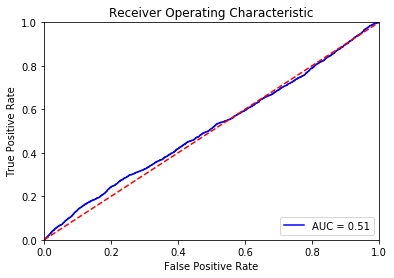

In [92]:
# print(roc_auc_score(y_test, probs[:,1]))
# y_test.to_numpy()
# len(probs[:,1])
fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The goal of the prediction is to predict correctly the number of patient that will be readmitted within 30 days. In this dataset, the class is imbalanced and looking at the business importance for hospitals is to be able to predict the the readmitted patient correctly. The result of the machine learning building using the sensitivity as metric is 0.75, which is quite good.